In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
url = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'

In [3]:
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36'
    ,'accept-encoding': 'gzip, deflate, br'
    ,'accept-language': 'en-US,en;q=0.9'    
}

In [4]:
session = requests.Session()
request = session.get(url, headers=headers)
cookies = dict(request.cookies)
response = session.get(url, headers=headers, cookies=cookies).json()
rawdata = pd.DataFrame(response)

In [5]:
df= pd.DataFrame(response["records"]['data']).fillna(0)

In [6]:
def option_dataframe(df):
    data = []
    df.sort_values(by=["expiryDate", "strikePrice"], ascending=True, inplace=True)
    for i in range(len(df)):
        call_oi = call_coi = put_oi = put_coi  = int(0)
        call_IV = put_IV = call_ltp = put_ltp = float(0)
        strike = df.iloc[i,0]
        expiry = df.iloc[i,1]
        if(df.iloc[i,-1] == 0):
            calloi = call_coi = 0
        else:
            call_oi = df.iloc[i,-1]["openInterest"]
            call_coi = df.iloc[i,-1]["changeinOpenInterest"]
            call_ltp = df.iloc[i,-1]['lastPrice']
            call_IV = df.iloc[i,-1]['impliedVolatility']
        
        if(df.iloc[i,-2] == 0):
            putoi = put_coi = 0
        else:
            put_oi = df.iloc[i,-2]["openInterest"]
            put_coi = df.iloc[i,-2]["changeinOpenInterest"]
            put_ltp = df.iloc[i,-2]['lastPrice']
            put_IV = df.iloc[i,-2]['impliedVolatility']
            
        option_data = {"Expiry": expiry,
            "Call OI" : call_oi, "Call C_OI" : call_coi,"Call IV": call_IV ,"Call LTP" : call_ltp, "STRIKE" : strike,
             "Put LTP" : put_ltp ,"Put IV" : put_IV , "Put C_OI" : put_coi, "Put OI" : put_oi
        }
        data.append(option_data)
    optionchain = pd.DataFrame(data)

    return optionchain , df.iloc[0,-1]["underlyingValue"]

In [7]:
optionchain  , underlying_ltp = option_dataframe(df) 

In [8]:
strike_list = pd.Series(optionchain["STRIKE"].unique()).sort_values(ascending=True)
expiries_list = pd.to_datetime(optionchain["Expiry"].unique()).sort_values(ascending=True)

In [10]:
def by_expiry(optionchain, cutoff = 50):
    option_dict = {}
    optionchain["Expiry"] = pd.to_datetime(optionchain["Expiry"])
    for i in  range(len(expiries_list)):
        option_dict[i] = optionchain.loc[optionchain["Expiry"] == expiries_list[i]]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["Expiry"], axis=1, inplace=True)
    return option_dict

In [11]:
def by_strike(optionchain, cutoff = 50):
    optionchain.sort_values(by=["STRIKE","Expiry"], inplace=True, ascending=True)
    option_dict = {}
    for i in  strike_list:
        option_dict[i] = optionchain.loc[optionchain["STRIKE"] == i]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call LTP"] == 0) | (option_dict[i]["Put LTP"] == 0)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["STRIKE"], axis=1, inplace=True)
    return option_dict

In [12]:
expiry = by_expiry(optionchain, cutoff = 100)
strike = by_strike(optionchain, cutoff = 100)

In [16]:
def plot_graph_expiry(options, expiry=0):
    plt.plot(options[expiry]["STRIKE"],options[expiry]["Call IV"])
    plt.plot(options[expiry]["STRIKE"],options[expiry]["Put IV"], color='r')#, figure=(20,16)
    plt.grid('True')
    plt.title("Option Skew")
    plt.xlabel("Strikes")
    plt.legend(["Call Skew","Put Skew"])
    plt.ylabel("Implied Volatility")
    plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

In [ ]:
def plot_graph_strike(option, strike=17100):
    option[strike]["Expiry"] = pd.to_datetime(option[strike]["Expiry"])
    plt.plot(option[strike]["Expiry"], option[strike]["Call IV"])
    plt.plot(option[strike]["Expiry"], option[strike]["Put IV"], color = 'r')
    plt.grid('True')
    plt.title("Term Structure of " + str(strike) + " option.")
    plt.legend(["Call Term Structure","Put Term Structure"])
    plt.ylabel("Implied Volatility")
#     plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

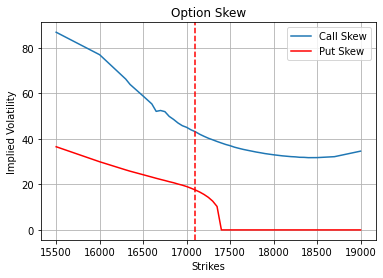

In [17]:
plot_graph_expiry(expiry, 0)

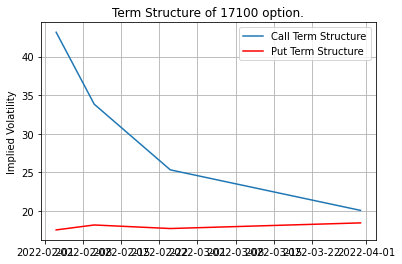

In [31]:
plot_graph_strike(strike, 17100)